<h1> Building the ML Pipeline </h1>

In [22]:
#data handling
import pandas as pd
import numpy as np

#visualisation
import matplotlib.pyplot as plt

#dividing into train/test
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model building
from sklearn.svm import SVR

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# to persist the model and the scaler
import joblib

# pipeline
from sklearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict


In [2]:
#defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('../backend/CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test = pd.read_csv('../backend/CMAPSSData/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul = pd.read_csv('../backend/CMAPSSDATA/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [4]:
def add_RUL_column(df):
    
    #get total number of cycles for each unit
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    
    #merge the max cycle back into original frame
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    
    #calculate remaining useful life for each row
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    #drop max cycle as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [5]:
train = add_RUL_column(train)

In [6]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

In [7]:
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(
    X_train.drop('RUL', axis=1), #predictor
    X_train['RUL'], #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility

<h1> Pipeline </h1>

In [8]:
SVR_base = Pipeline([
    ('scaler', MinMaxScaler()),
    ('SVR', SVR(kernel = 'rbf')),
])

In [9]:
SVR_base.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('SVR', SVR())])

<h1> Evaluating </h1>

In [10]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [11]:
pred_train = SVR_base.predict(X_train)
evaluate(y_train, pred_train)

pred_test = SVR_base.predict(X_test)
evaluate(y_test, pred_test)

test set RMSE:43.578672467219796, R2:0.602735270009432, MAE:30.83375430314257
test set RMSE:43.23510678542852, R2:0.5988823106078376, MAE:30.65206636447211


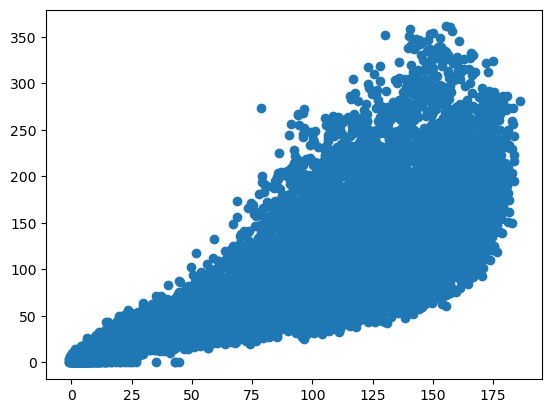

In [12]:
plt.scatter(pred_train, y_train)

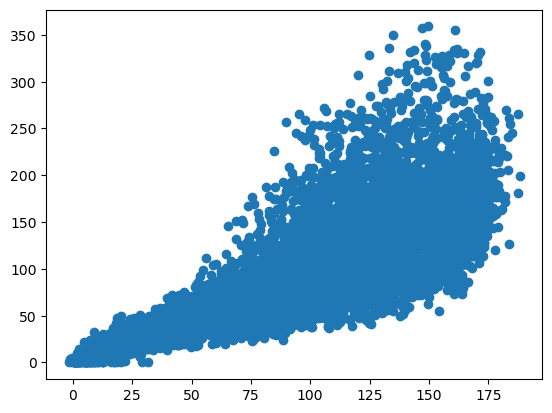

In [13]:
plt.scatter(pred_test, y_test)

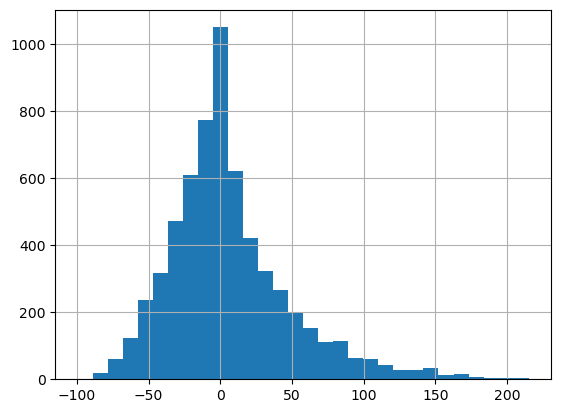

In [15]:
y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(SVR_base.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [20]:
save_path = "../backend/"

# Serialize the trained model to a file in the specified location
joblib.dump(SVR_base, save_path + 'SVR_base.pkl')

['../backend/SVR_base.pkl']

<h1> Scoring new data </h1>

In [16]:
X_valid = test.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

In [18]:
new_pred = SVR_base.predict(X_valid)
evaluate(rul, new_pred, label = 'valid')

valid set RMSE:26.12385549824232, R2:0.6048017603106537, MAE:19.026271433361345


Text(0.5, 1.0, 'Evaluation of RUL Predictions using SVR')

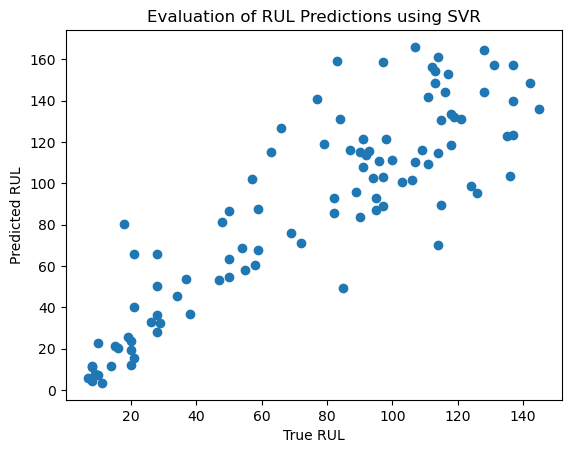

In [24]:
plt.scatter(rul, new_pred)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Evaluation of RUL Predictions using SVR')

<h2> Cross Validation </h2>

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set
cv_predictions_train = cross_val_predict(SVR_base, X_train, y_train, cv=kf)

# Evaluate cross-validated predictions on training set
evaluate(y_train, cv_predictions_train, label='cross-validation on training')

# Fit the pipeline to the entire training set
SVR_base.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = SVR_base.predict(X_test)

# Evaluate the model on the test set
evaluate(y_test, test_predictions, label='test')

cross-validation on training set RMSE:43.83185268819781, R2:0.5981058613386994, MAE:31.07979571448288
test set RMSE:43.23510678542852, R2:0.5988823106078376, MAE:30.65206636447211
